In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score

### Neural Network from Scratch

In this notebook, we will build a Multi-Layer Perceptron (MLP) from scratch. An MLP is a Feed-Forward and Fully Connected Neural Network that contains one or more hidden layers apart from input and output layer. We will build the Neural Network with one hidden layer.
 
We will use the SEEDS dataset to build a Neural Network. The target contains 3 classes. It's a classification problem.

The steps for training a neural network are as follows:
1. **Training:**
    1. Split data into training and validation sets
    2. Initialize random weights and biases
    3. For an epoch:
        1. For each batch:
            1. **Forward Pass:** Propagate through the network and calculate loss
            2. **Backward Pass (Back-Propagation):**
                1. Back-propagate through the network to calculate gradient of loss with respect to weights and biases
                2. Update the weights and biases using an optimizer 
        2. Calculate mean training loss across all batches for the epoch
        3. Calculate validation loss with final weights and biases at end of epoch
    4. Repeat step 3 for significant number of epochs until loss convergence
2. **Inference:**
    1. Using final weights and biases, predict on testing data 

In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt

--2022-01-18 00:21:08--  https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9300 (9.1K) [application/x-httpd-php]
Saving to: ‘seeds_dataset.txt’

seeds_dataset.txt   100%[===================>]   9.08K  --.-KB/s    in 0s      

2022-01-18 00:21:10 (43.5 MB/s) - ‘seeds_dataset.txt’ saved [9300/9300]



In [3]:
def make_data(path):
    with open(path) as f:
        data = f.read().splitlines()    
    data = list(map(lambda x: x.split('\t'), data))          

    # preprocessing data
    n_cols = np.array(list(map(lambda x: len(x), data)))
    chosen_idxs = np.where(n_cols==8)[0]
    data = list(map(lambda x: data[x], chosen_idxs))
    return data

In [4]:
def get_train_test_split(data, target_label, test_size, random_state):
    df = pd.DataFrame(data).astype('float')
    target = df[target_label]
    target = pd.get_dummies(target)
    df.drop(columns=target_label, inplace=True)
    X = df.values
    
    # normalization for faster convergence
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    y = target.values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    return X_train, X_test, y_train, y_test

In [5]:
target_label = 7
test_size = 0.2
random_state = 42
data_path = 'seeds_dataset.txt'

data = make_data(data_path)
X_train, X_test, y_train, y_test = get_train_test_split(data, target_label, test_size, random_state)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((159, 7), (40, 7), (159, 3), (40, 3))

#### Forward equations:
$$
\begin{aligned}
&Z_{1}=X W_{1}+B_{1} \\
&Y_{1}=\sigma\left(Z_{1}\right) \\
&Z_{2}=Y_{1} W_{2}+B_{2}
\end{aligned}
\\
\hat{y}=\operatorname{softmax}\left(Z_{2}\right)
$$

#### Backward equations:
$$
\begin{aligned}
&d z_{2}=\frac{\partial L}{\partial z_{2}}=\frac{\hat{y}-y}{N} \\
&d Y_{1}=\frac{\partial L}{\partial y_{1}}=d Z_{2} \cdot W_{2}^{\top} \\
&d Z_{1}=d Y_{1} * Y_{1} * 1-Y_{1} \\
&d W_{2}=Y_{1}^{\top} d Z_{2} \\
&d B_{2}=d Z_{2} 1 \\
&d W_{1}=X^{\top} d Z_{1} \\
&d B_{1}=d Z_{1} 1
\end{aligned}
$$

In [6]:
def initialize_weights(batch_size, n_input, n_hidden, n_output):
    W1 = np.random.normal(-1, 1, size=(n_input, n_hidden))
    W2 = np.random.normal(-1, 1, size=(n_hidden, n_output))
    B1 = np.random.normal(-1, 1, size=(batch_size, 1))
    B2 = np.random.normal(-1, 1, size=(batch_size, 1))
    return W1, W2, B1, B2

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def dsigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=1).reshape(-1,1)      

def cross_entropy_loss(y_batch, y_score):
    return -np.sum(np.multiply(y_batch, np.log(y_score))) / len(y_batch)    

def forward(X_batch, y_batch, W1, B1, W2, B2):
    Z1 = X_batch @ W1 + B1
    Y1 = sigmoid(Z1)
    Z2 = Y1 @ W2 + B2
    y_score = softmax(Z2)
    L = cross_entropy_loss(y_batch, y_score)
    return Z1, Z2, Y1, y_score, L   

def gradient(W1, W2, B1, B2, Z1, Z2, Y1, y_score, X_batch, y_batch, n_hidden, n_output):
    dZ2 = (y_score - y_batch) / len(y_batch)
    dY1 = dZ2 @ W2.T
    dZ1 = dY1 * dsigmoid(Y1)
    dW2 = Y1.T @ dZ2
    dB2 = dZ2 @ np.ones(shape=(n_output,1))
    dW1 = X_batch.T @ dZ1
    dB1 = dZ1 @ np.ones(shape=(n_hidden,1))

    assert dZ2.shape == Z2.shape
    assert dY1.shape == Y1.shape
    assert dZ1.shape == Z1.shape
    assert dW2.shape == W2.shape
    assert dB2.shape == B2.shape
    assert dW1.shape == W1.shape
    assert dB1.shape == B1.shape
    return dW1, dW2, dB1, dB2     

def updates(W1, W2, B1, B2, dW1, dW2, dB1, dB2, alpha):
    W1 = W1 - alpha * dW1
    W2 = W2 - alpha * dW2
    B1 = B1 - alpha * dB1
    B2 = B2 - alpha * dB2
    return W1, W2, B1, B2

def backward(W1, W2, B1, B2, Z1, Z2, Y1, y_score, X_batch, y_batch, alpha):
    dW1, dW2, dB1, dB2 = gradient(W1, W2, B1, B2, Z1, Z2, Y1, y_score, X_batch, y_batch, n_hidden, n_output)
    W1, W2, B1, B2 = updates(W1, W2, B1, B2, dW1, dW2, dB1, dB2, alpha)
    return W1, W2, B1, B2

In [7]:
def training(X_train, y_train, W1, W2, B1, B2, alpha, batch_size):
    n_examples = X_train.shape[0]
    
    batch_runs = int(n_examples / batch_size)
    loss = 0
    for batch_idx in range(batch_runs):
        batch_start = batch_idx * batch_size
        batch_end = min((batch_idx + 1) * batch_size, n_examples)
        X_batch = X_train[batch_start:batch_end]
        y_batch = y_train[batch_start:batch_end]
        Z1, Z2, Y1, y_score, L = forward(X_batch, y_batch, W1, B1, W2, B2)
        W1, W2, B1, B2 = backward(W1, W2, B1, B2, Z1, Z2, Y1, y_score, X_batch, y_batch, alpha)
        loss += L

    mean_loss = loss / batch_runs
    return W1, W2, B1, B2, mean_loss   

In [8]:
def evaluate(X_test, y_test, W1, W2, B1, B2, batch_size):
    n_examples = X_test.shape[0]
    
    batch_runs = int(n_examples / batch_size)
    loss = 0
    y_scores = []
    for batch_idx in range(batch_runs):
        batch_start = batch_idx * batch_size
        batch_end = min((batch_idx + 1) * batch_size, n_examples)
        X_batch = X_test[batch_start:batch_end]
        y_batch = y_test[batch_start:batch_end]
        Z1, Z2, Y1, y_score, L = forward(X_batch, y_batch, W1, B1, W2, B2)
        loss += L
        y_scores.append(y_score)
        
    mean_loss = loss / batch_runs
    y_scores = np.array(y_scores).reshape(-1, y_score.shape[1])
    return mean_loss, y_scores

In [9]:
def get_accuracy(y_test, y_scores):
    y_test = y_test[:len(y_scores)]
    assert y_test.shape == y_scores.shape
    y_true = np.flip(np.argsort(y_test, axis=1), axis=1)[:,0]
    y_pred = np.flip(np.argsort(y_scores, axis=1), axis=1)[:,0]
    return balanced_accuracy_score(y_true, y_pred)

#### Hyperparameters - Learning Rate and Batch Size

**Batch Size:** It's important to choose an appropriate batch size for training neural network. A small batch size can result in noisy gradients leading to unstable learning and is prone to bias. A large batch size can lead into memory issues as gradients are being computed for too many examples.

**Learning Rate:** Similarly, an appropriate learning rate is important too. A shallow learning rate will lead into larger training time and potentially getting stuck into local minima. A large learning rate will result in oscillations therby not really converging at global minima.

In [10]:
alpha = 1E-3
num_epochs = 1000
n_input = X_train.shape[1]
n_hidden = 32
n_output = 3
batch_size = 16

history = {}
for epoch_idx in range(num_epochs):
    if epoch_idx ==0:
        W1, W2, B1, B2 = initialize_weights(batch_size, n_input, n_hidden, n_output)
    W1, W2, B1, B2, train_loss = training(X_train, y_train, W1, W2, B1, B2, alpha, batch_size)
    val_loss, y_scores = evaluate(X_test, y_test, W1, W2, B1, B2, batch_size)
    history[epoch_idx]= [train_loss, val_loss]

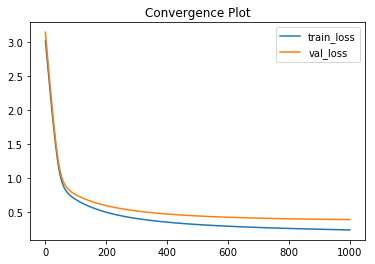

Accuracy Score: 0.845


In [11]:
losses = np.array(list(history.values()))
plt.title('Convergence Plot')
plt.plot(losses[:,0], label='train_loss')
plt.plot(losses[:,1], label='val_loss')
plt.legend()
plt.show()

acc_score = get_accuracy(y_test, y_scores)
print('Accuracy Score:', acc_score.round(3))